In [1]:
%reset -fs

In [2]:
import requests as r
import pandas as pd
import xgboost as xgb
import seaborn as sns

c:\Users\nated\anaconda3\envs\metis\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
diamond_df = pd.read_csv('diamonds.csv', index_col=0)

In [4]:
diamond_df.head(20)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [5]:
diamond_df.shape

(53940, 10)

In [6]:
diamond_df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
diamond_df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [8]:
diamond_df.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [9]:
diamond_df.color.value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [10]:
diamond_df.clarity.value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

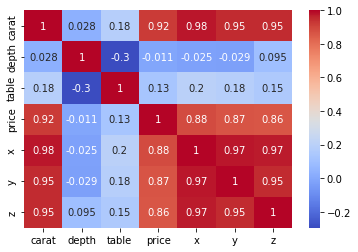

In [11]:
sns.heatmap(diamond_df.corr(), annot=True, cmap='coolwarm');